In [6]:
import os
import cv2
import json
import matplotlib.pyplot as plt
import numpy as np
from utils import detectAirportRunway, computehoughTransformCoord

path = "AirportRunway618"
images = []
labels = []
nums = []
for file in os.listdir(path):
    if file.endswith(".jpg"):
        num = int(file[8:-4])
        if num < 300:
            continue
        image_path = os.path.join(path, file)
        images.append(image_path)
        nums.append(num)
    if file.endswith(".json"):
        num = int(file[8:-5])
        if num < 300:
            continue
        label_path = os.path.join(path, file)
        labels.append(label_path)

rho0ErrorList = []
rho1ErrorList = []
theta0ErrorList = []
theta1ErrorList = []

for i in range(len(images)):
    # if i != 200:
    #     continue

    image = cv2.imread(images[i])
    if image is None:
        print(f"image not found, path {images[i]}")

    with open(labels[i], "r") as f:
        label = json.load(f)
        uv1 = label["RunwayVertexCoord"]["Coord1"]["UVCoord"]
        uv2 = label["RunwayVertexCoord"]["Coord2"]["UVCoord"]
        uv3 = label["RunwayVertexCoord"]["Coord3"]["UVCoord"]
        uv4 = label["RunwayVertexCoord"]["Coord4"]["UVCoord"]

    # calculate runway boundary and rescale
    width, height, _ = image.shape
    r = 0.3 # scale factor
    xmax = max(uv1[0], uv2[0], uv3[0], uv4[0])
    xmin = min(uv1[0], uv2[0], uv3[0], uv4[0])
    ymax = max(uv1[1], uv2[1], uv3[1], uv4[1])
    ymin = min(uv1[1], uv2[1], uv3[1], uv4[1])
    xlen = xmax - xmin
    ylen = ymax - ymin
    Bxmin = max(xmin - xlen * r, 0)
    Bxmax = min(xmax + xlen * r, width)
    Bymin = max(ymin - ylen * r, 0)
    Bymax = min(ymax + ylen * r, height)
    cv2.imwrite("origin/" + str(nums[i]) + ".jpg", image[int(Bymin):int(Bymax), int(Bxmin):int(Bxmax)])

    # ground truth
    theta0, rho0, _ = computehoughTransformCoord(uv1[0], uv1[1], uv2[0], uv2[1])
    theta1, rho1, _= computehoughTransformCoord(uv3[0], uv3[1], uv4[0], uv4[1])

    line0, line1 = detectAirportRunway(image[int(Bymin):int(Bymax), int(Bxmin):int(Bxmax)], draw=True, res_name=str(nums[i]))
    if abs(line0[0] - theta0) < abs(line0[0] - theta1):
        theta0_, rho0_ = line0
        theta1_, rho1_ = line1
    else:
        theta0_, rho0_ = line1
        theta1_, rho1_ = line0
    
    rho0_ += int(Bxmin)*np.cos(theta0_) + int(Bymin)*np.sin(theta0_)
    rho1_ += int(Bxmin)*np.cos(theta1_) + int(Bymin)*np.sin(theta1_)
    
    theta0ErrorList.append(theta0_-theta0)
    theta1ErrorList.append(theta1_-theta1)
    rho0ErrorList.append(rho0_-rho0)
    rho0ErrorList.append(rho1_-rho1)

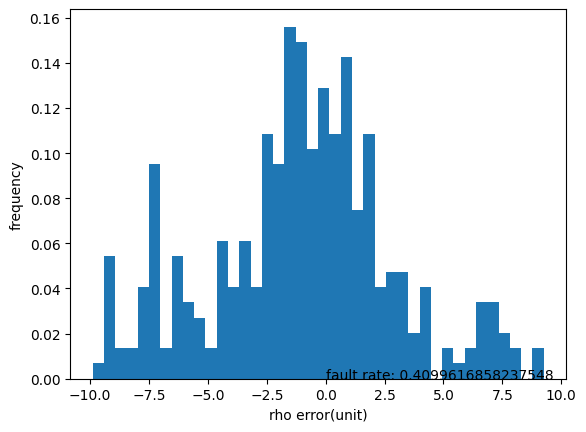

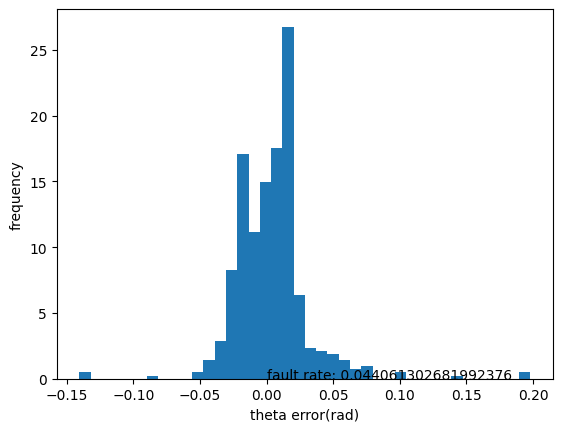

In [8]:
rhoErrorList = rho0ErrorList + rho1ErrorList
rhoErrorListM = [x for x in rhoErrorList if abs(x)<10]
thetaErrorList = theta0ErrorList + theta1ErrorList
thetaErrorListM = [x for x in thetaErrorList if abs(x)<1]

plt.figure()
plt.hist(rhoErrorListM, bins=40, density=True)
plt.xlabel("rho error(unit)")
plt.ylabel("frequency")
plt.text(0, 0, f"fault rate: {1 - len(rhoErrorListM)/len(rhoErrorList)}")

plt.figure()
plt.hist(thetaErrorListM, bins=40, density=True)
plt.xlabel("theta error(rad)")
plt.ylabel("frequency")
plt.text(0, 0, f"fault rate: {1 - len(thetaErrorListM)/len(thetaErrorList)}")
plt.show()